__LAPLACE CUDA__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


def plot_solution(x_star, y_star, u_star):    
    nn = 200
    x = np.linspace(x_star.min(), x_star.max(), nn)
    y = np.linspace(y_star.min(), y_star.max(), nn)
    X, Y = np.meshgrid(x,y)   
    X_star = np.concatenate((x_star, y_star), axis=1)    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='linear')
    h = plt.imshow(U_star, interpolation='nearest', cmap='jet', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
                  origin='lower', aspect='auto')    
    return h

def plot(x, y, u, title):
  x_plot = np.reshape(x,(x.shape[0]*x.shape[1],1), order="F") 
  y_plot = np.reshape(y,(x.shape[0]*x.shape[1],1), order="F") 
  u_plot = np.reshape(u,(x.shape[0]*x.shape[1],1), order="F") 
  fig, ax = plt.subplots()   
  h = plot_solution(x_plot, y_plot, u_plot)   
  fig.colorbar(h)
  plt.xlabel('x')  
  plt.ylabel('y')  
  plt.title(f'{title}') 
  plt.show() 

Computation time =  29.47 seconds


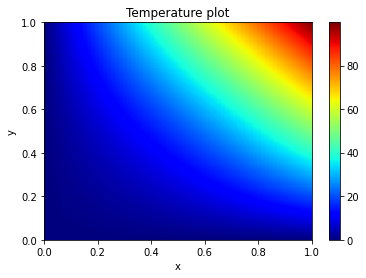

In [2]:
from __future__ import division
from numba import cuda, float32
import numpy as np
import math
import time

nc = 512 ; nr = 512 ; niter = 100000; 
Lx = 1.0 ; Ly = 1.0 ; 
xx = np.linspace(0,Lx,nr)
yy = np.linspace(0,Ly,nc)
x, y = np.meshgrid(xx,yy)
    
T = np.zeros((nr,nc)); 
Told = np.zeros((nr,nc));         

def initialize(T):
  for i in range(nr):
    for j in range(nc):
      T[i,j] = 0.0;

def set_bcs(T):
  for i in range(nr):
    T[i,0] = 0.0
    T[i,nr-1] = (100.0/nr)*i;
    
  for j in range(nc):
    T[0,j] = 0.0
    T[nc-1,j] = (100.0/nc)*j;

@cuda.jit
def compute(T, Told):
  i, j = cuda.grid(2)  
  imax, jmax = T.shape
  if 1 <= i < imax-1 and 1 <= j < jmax-1:  
    T[i,j]=0.25*(Told[i-1,j]+Told[i+1,j]+Told[i,j-1]+Told[i,j+1]);

@cuda.jit
def update(T, Told):  
  i,j = cuda.grid(2)
  Told[i,j]=T[i,j];

# Configure the blocks
threads_per_block = (32, 32)
blockspergrid_x = int(math.ceil(T.shape[0] / threads_per_block[0]))
blockspergrid_y = int(math.ceil(T.shape[1] / threads_per_block[1]))
blocks_per_grid = (blockspergrid_x, blockspergrid_y)

start_time = time.time();
initialize(T);             
set_bcs(T); 

for i in range(nr):
  for j in range(nc):
    Told[i,j] = T[i,j]        

# Copy the arrays to the device
T_global_mem = cuda.to_device(T)
Told_global_mem = cuda.to_device(Told)

for iter in range(niter):
  compute[blocks_per_grid,threads_per_block](T_global_mem,Told_global_mem);
  update[blocks_per_grid,threads_per_block](T_global_mem,Told_global_mem);

elapsed = time.time() - start_time
print('Computation time =  %.2f seconds'%(elapsed))

T = T_global_mem.copy_to_host()

plot(x, y, T, title = 'Temperature plot')